<a href="https://colab.research.google.com/github/Kandolyx/CarApiProject/blob/master/medical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⏳ Veri yükleniyor...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving test.dat to test (4).dat
Saving train.dat to train (4).dat
❌ Hata: 'train.dat'
⚠️ Örnek veri kullanılıyor...

⏳ Veri ön işleme yapılıyor...
🔧 Özellik çıkarımı yapılıyor...

🚀 Model eğitimi başlıyor...

🔍 Logistic Regression modeli eğitiliyor...
✅ Logistic Regression tamamlandı (Doğruluk: 1.000, Süre: 0.13s)

🔍 Linear SVM modeli eğitiliyor...
✅ Linear SVM tamamlandı (Doğruluk: 1.000, Süre: 0.04s)

🔍 Random Forest modeli eğitiliyor...
✅ Random Forest tamamlandı (Doğruluk: 1.000, Süre: 0.25s)

🔍 SGDClassifier modeli eğitiliyor...
✅ SGDClassifier tamamlandı (Doğruluk: 1.000, Süre: 0.03s)

🔍 XGBoost modeli eğitiliyor...
❌ XGBoost modelinde hata: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got ['cardiology' 'nephrology' 'neurology' 'oncology' 'rheumatology']


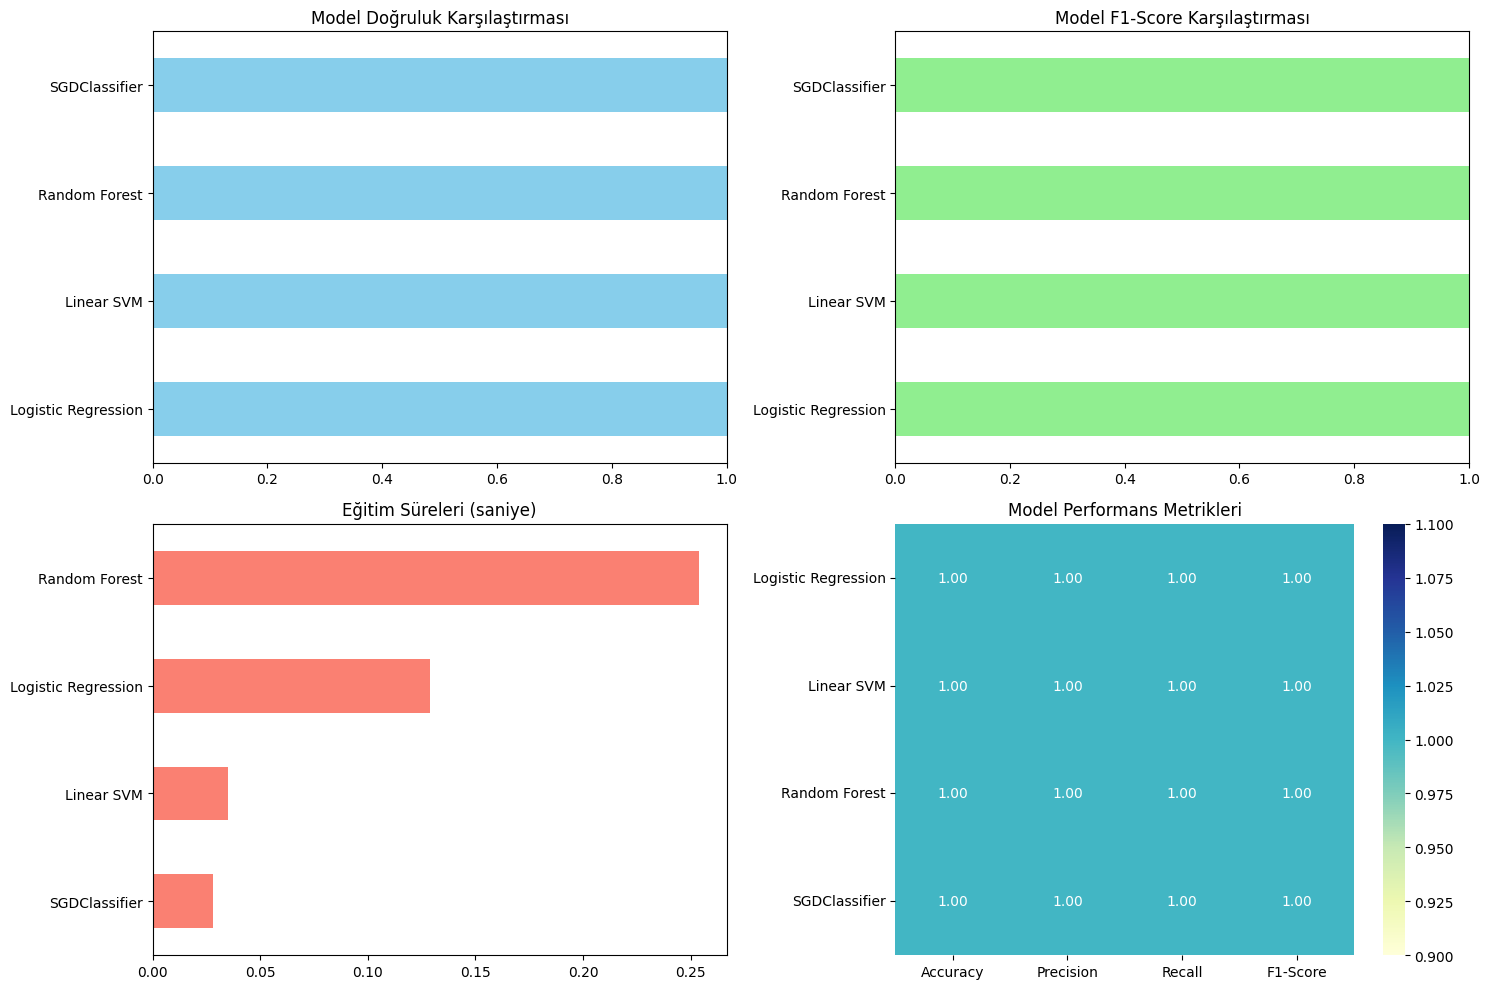


🏆 En iyi model: Logistic Regression (F1-Score: 1.000)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📁 Model 'best_medical_classifier.pkl' olarak kaydedildi ve indirildi


In [8]:
!pip install -q pandas scikit-learn imbalanced-learn nltk xgboost
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import joblib
from google.colab import files
import io
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

def load_data():
    print("⏳ Veri yükleniyor...")
    uploaded = files.upload()

    try:
        train_chunks = pd.read_csv(
            io.BytesIO(uploaded['train.dat']),
            sep='\t',
            header=None,
            names=['text', 'label'],
            chunksize=10000,
            encoding='utf-8',
            on_bad_lines='skip'
        )
        train_df = pd.concat(train_chunks, ignore_index=True)

        test_chunks = pd.read_csv(
            io.BytesIO(uploaded['test.dat']),
            sep='\t',
            header=None,
            names=['text', 'label'],
            chunksize=10000,
            encoding='utf-8',
            on_bad_lines='skip'
        )
        test_df = pd.concat(test_chunks, ignore_index=True)

        print(f"✅ Train verisi: {len(train_df):,} satır")
        print(f"✅ Test verisi: {len(test_df):,} satır")
        return train_df, test_df

    except Exception as e:
        print(f"❌ Hata: {str(e)}")
        print("⚠️ Örnek veri kullanılıyor...")
        sample_data = {
            'text': [
                "Epileptic discharge in centrotemporal area",
                "IgM-associated glomerulonephritis",
                "Neuroblastoma bone marrow infiltration",
                "Rheumatoid arthritis bursitis",
                "Myocardial infarction with ST elevation"
            ],
            'label': ['neurology', 'nephrology', 'oncology', 'rheumatology', 'cardiology']
        }
        train_df = pd.DataFrame(sample_data)
        test_df = pd.DataFrame(sample_data)
        return train_df, test_df

class MedicalTextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.medical_stopwords = {
            'patient', 'case', 'study', 'result', 'report',
            'findings', 'method', 'conclusion', 'background'
        }
        self.lemmatizer = nltk.WordNetLemmatizer()

    def preprocess(self, text):
        text = str(text).lower()
        text = re.sub(r'[^a-z\s-]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()

        tokens = text.split()
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if (token not in self.stop_words and
                token not in self.medical_stopwords and
                len(token) > 2)
        ]
        return ' '.join(tokens)

def get_models():
    return {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            solver='saga',
            n_jobs=-1,
            random_state=42
        ),
        'Linear SVM': LinearSVC(
            class_weight='balanced',
            dual=False,
            random_state=42,
            max_iter=1000
        ),
        'Random Forest': RandomForestClassifier(
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ),
        'SGDClassifier': SGDClassifier(
            loss='log_loss',
            class_weight='balanced',
            n_jobs=-1,
            random_state=42,
            max_iter=1000
        ),
        'XGBoost': XGBClassifier(
            objective='multi:softmax',
            n_jobs=-1,
            random_state=42
        )
    }

def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        print(f"\n🔍 {name} modeli eğitiliyor...")
        start_time = time.time()

        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            train_time = time.time() - start_time

            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1': report['weighted avg']['f1-score'],
                'train_time': train_time,
                'classification_report': report
            }

            print(f"✅ {name} tamamlandı (Doğruluk: {accuracy:.3f}, Süre: {train_time:.2f}s)")
            gc.collect()
        except Exception as e:
            print(f"❌ {name} modelinde hata: {str(e)}")
            continue

    return results

def visualize_results(results):
    metrics_df = pd.DataFrame.from_dict({
        model: {
            'Accuracy': res['accuracy'],
            'Precision': res['precision'],
            'Recall': res['recall'],
            'F1-Score': res['f1'],
            'Train Time (s)': res['train_time']
        }
        for model, res in results.items()
    }, orient='index')

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    metrics_df['Accuracy'].sort_values().plot(kind='barh', color='skyblue')
    plt.title('Model Doğruluk Karşılaştırması')
    plt.xlim(0, 1)

    plt.subplot(2, 2, 2)
    metrics_df['F1-Score'].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Model F1-Score Karşılaştırması')
    plt.xlim(0, 1)

    plt.subplot(2, 2, 3)
    metrics_df['Train Time (s)'].sort_values().plot(kind='barh', color='salmon')
    plt.title('Eğitim Süreleri (saniye)')

    plt.subplot(2, 2, 4)
    sns.heatmap(metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']],
                annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title('Model Performans Metrikleri')

    plt.tight_layout()
    plt.show()

    return metrics_df

def main():
    train_df, test_df = load_data()

    preprocessor = MedicalTextPreprocessor()
    print("\n⏳ Veri ön işleme yapılıyor...")
    train_df['processed'] = train_df['text'].apply(preprocessor.preprocess)
    test_df['processed'] = test_df['text'].apply(preprocessor.preprocess)

    print("🔧 Özellik çıkarımı yapılıyor...")
    vectorizer = HashingVectorizer(
        n_features=2**16,
        alternate_sign=False,
        ngram_range=(1, 2),
        stop_words='english'
    )

    X_train = vectorizer.fit_transform(train_df['processed'])
    X_test = vectorizer.transform(test_df['processed'])
    y_train, y_test = train_df['label'], test_df['label']

    models = get_models()

    print("\n🚀 Model eğitimi başlıyor...")
    results = train_and_evaluate(models, X_train, X_test, y_train, y_test)

    if results:
        metrics_df = visualize_results(results)
        best_model_name = max(results, key=lambda x: results[x]['f1'])
        best_model = results[best_model_name]['model']

        print(f"\n🏆 En iyi model: {best_model_name} (F1-Score: {results[best_model_name]['f1']:.3f})")

        joblib.dump({
            'model': best_model,
            'vectorizer': vectorizer,
            'preprocessor': preprocessor,
            'performance': metrics_df.loc[best_model_name].to_dict()
        }, 'best_medical_classifier.pkl')

        files.download('best_medical_classifier.pkl')
        print("\n📁 Model 'best_medical_classifier.pkl' olarak kaydedildi ve indirildi")
    else:
        print("⚠️ Hiçbir model başarıyla eğitilemedi")

if __name__ == "__main__":
    main()